# An agent for interacting with a SQL database

In this tutorial, we will walk through how to build an agent that can answer questions about a SQL database. 

At a high level, the agent will:
1. Fetch the available tables from the database
2. Decide which tables are relevant to the question
3. Fetch the DDL for the relevant tables
4. Generate a query based on the question and information from the DDL
5. Double-check the query for common mistakes using an LLM
6. Execute the query and return the results
7. Correct mistakes surfaced by the database engine until the query is successful
8. Formulate a response based on the results

The end-to-end workflow will look something like below:

![](sql-agent-diagram.png)

## Set up environment

We'll set up our environment variables for OpenAI, and optionally, to enable tracing with [LangSmith](https://smith.langchain.com).

In [2]:
import os

os.environ["OPENAI_API_KEY"] = "sk-..."
os.environ["LANGSMITH_API_KEY"] = "lsv2_pt_..."
os.environ["LANGCHAIN_TRACING_V2"] = "true"

## Configure the database

We will be creating a SQLite database for this tutorial. SQLite is a lightweight database that is easy to set up and use. We will be loading the `chinook` database, which is a sample database that represents a digital media store.
Find more information about the database [here](https://www.sqlitetutorial.net/sqlite-sample-database/).

For convenience, we have hosted the database (`Chinook.db`) on a public GCS bucket.

In [19]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("Chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db


We will use a handy SQL database wrapper available in the `langchain_community` package to interact with the database. The wrapper provides a simple interface to execute SQL queries and fetch results. We will also use the `langchain_openai` package to interact with the OpenAI API for language models later in the tutorial.

In [4]:
%%capture --no-stderr --no-display
!pip install langchain_community langchain_openai

In [5]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

## Utility functions

We will define a few utility functions to help us with the agent implementation. Specifically, we will wrap a `ToolNode` with a fallback to handle errors and surface them to the agent.

In [6]:
from typing import Any, Dict, List

from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langchain_core.messages import ToolMessage, AIMessage

from langgraph.prebuilt import ToolNode

def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

## Define tools for the agent

We will define a few tools that the agent will use to interact with the database.

1. `list_tables_tool`: Fetch the available tables from the database
2. `get_schema_tool`: Fetch the DDL for a table
3. `db_query_tool`: Execute the query and fetch the results OR return an error message if the query fails

For the first two tools, we will grab them from the `SQLDatabaseToolkit`, also available in the `langchain_community` package.

In [7]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI

toolkit = SQLDatabaseToolkit(db=db, llm=ChatOpenAI(model="gpt-4o"))
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

print(list_tables_tool.invoke(""))

print(get_schema_tool.invoke("Artist"))

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


The third will be defined manually. For the `db_query_tool`, we will execute the query against the database and return the results.

In [20]:
from langchain.agents import tool

@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result

print(db_query_tool.invoke("SELECT * FROM Artist LIMIT 10;"))

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


While not strictly a tool, we will prompt an LLM to check for common mistakes in the query and later add this as a node in the workflow.

In [9]:
from langchain_core.prompts import ChatPromptTemplate

query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages([("system", query_check_system),("placeholder", "{messages}")])
query_check = query_check_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools([db_query_tool], tool_choice="required")

query_check.invoke({"messages": [("user", "SELET * FROM Artist LIMIT 10;")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XnWquGNTWbJ2uhXO9hTLq2Zg', 'function': {'arguments': '{\n  "query": "SELECT * FROM Artist LIMIT 10;"\n}', 'name': 'db_query_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 222, 'total_tokens': 242}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_319be4768e', 'finish_reason': 'stop', 'logprobs': None}, id='run-aed5d66c-73fe-4fe1-bff5-c0b28e96f851-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM Artist LIMIT 10;'}, 'id': 'call_XnWquGNTWbJ2uhXO9hTLq2Zg'}], usage_metadata={'input_tokens': 222, 'output_tokens': 20, 'total_tokens': 242})

## Define the workflow

We will then define the workflow for the agent. The agent will first force-call the `list_tables_tool` to fetch the available tables from the database, then follow the steps mentioned at the beginning of the tutorial.

In [16]:
from typing import Annotated, Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt.tool_node import ToolNode
from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field

# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Define a new graph
workflow = StateGraph(State)

# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {
                        },
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }

def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    return {
        "messages": [
            query_check.invoke({"messages": [state["messages"][-1]]})
        ]
    }

workflow.add_node("first_tool_call", first_tool_call)

# Add nodes for the first two tools
workflow.add_node("list_tables_tool", create_tool_node_with_fallback([list_tables_tool]))
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# Add a node for a model to choose the relevant tables based on the question and available tables
model_get_schema = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools([get_schema_tool])
workflow.add_node("model_get_schema", lambda state: {"messages": [model_get_schema.invoke(state["messages"])],})

# Describe a tool to represent the end state
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""
    final_answer: str = Field(..., description="The final answer to the user")

# Add a node for a model to generate a query based on the question and schema
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set. 
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""
query_gen_prompt = ChatPromptTemplate.from_messages([("system", query_gen_system),("placeholder", "{messages}")])
query_gen = query_gen_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools([SubmitFinalAnswer])
def query_gen_node(state: State):
    message = query_gen.invoke(state)
    
    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}

workflow.add_node("query_gen", query_gen_node)

# Add a node for the model to check the query before executing it
workflow.add_node("correct_query", model_check_query)

# Add node for executing the query
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

# Define a conditional edge to decide whether to continue or end the workflow
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is a tool call, then we finish
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"

# Specify the edges between the nodes
workflow.set_entry_point("first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# Compile the workflow into a runnable
app = workflow.compile()

## Visualize the graph

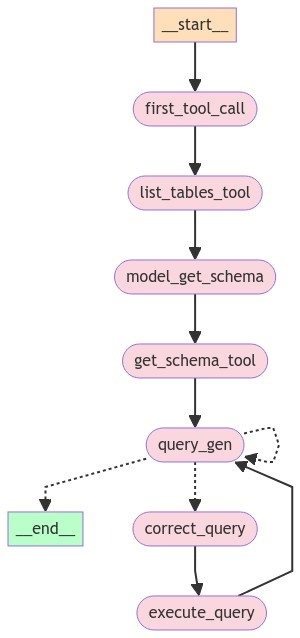

In [17]:
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Run the agent

In [18]:
for event in app.stream({"messages": [("user", "Which sales agent made the most in sales in 2009?")]}):
    print(event)

{'first_tool_call': {'messages': [AIMessage(content='', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123'}])]}}
{'list_tables_tool': {'messages': [ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', tool_call_id='tool_abcd123')]}}
{'model_get_schema': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zwAtGmtcszZIu0pMOWjd6kaN', 'function': {'arguments': '{"table_names":"Employee, Invoice"}', 'name': 'sql_db_schema'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 177, 'total_tokens': 195}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_319be4768e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-488a21dc-549b-4cde-b5e6-f261bfd18e61-0', tool_calls=[{'name': 'sql_db_schema', 'args': {'table_names': 'Employee, Invoice'}, 'id': 'call_zwAtGmtcszZIu0pMOWjd6kaN'}], usa